In [121]:
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score,f1_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# Load your dataset
df = pd.read_csv("fraud_reduced.csv", index_col=0)


In [123]:
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.33, stratify=y)

undersample = RandomUnderSampler(sampling_strategy=0.05, random_state=42)  
smote = SMOTE(sampling_strategy='auto', random_state=42)

pipeline = Pipeline([
    ('under', undersample),
    ('over', smote)
])

# Apply the pipeline to balance the training set
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [124]:
len(X_train_resampled)

13200

In [125]:
# Define a parameter grid to search over
param_grid = {
    'C': [900,1000],
    'kernel': ['rbf'],
    'degree': [1, 2],
}

# Create the SVM classifier
rnd_clf = SVC(probability=True, random_state=42)

scoring = {
    'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
    'f1_score': make_scorer(f1_score),
}

# Create a GridSearchCV instance with cross-validation
grid_search = GridSearchCV(
    rnd_clf,
    param_grid=param_grid,  
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=None),  # Cross-validation strategy
    n_jobs=-1,  # Use all available CPU cores
    scoring=scoring,
    refit='roc_auc',
    verbose=2,
)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [900, 1000], 'degree': [1, 2], 'kernel': ['rbf']},
             refit='roc_auc',
             scoring={'f1_score': make_scorer(f1_score),
                      'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
             verbose=2)

In [126]:
grid_search.best_params_

{'C': 1000, 'degree': 1, 'kernel': 'rbf'}

In [127]:
cvres = grid_search.cv_results_
roc_auc_scores = cvres['mean_test_roc_auc']
f1_scores = cvres['mean_test_f1_score']
results = list(zip(roc_auc_scores, f1_scores, cvres["params"]))
results.sort(reverse=True, key=lambda x: x[0])
for roc_auc_score, f1_score, params in results:
    print("ROC AUC:", roc_auc_score, "- F1 Score:", f1_score, "- Parameters:", params)

ROC AUC: 0.9792046602387512 - F1 Score: 0.9419152390611053 - Parameters: {'C': 1000, 'degree': 1, 'kernel': 'rbf'}
ROC AUC: 0.9792046602387512 - F1 Score: 0.9419152390611053 - Parameters: {'C': 1000, 'degree': 2, 'kernel': 'rbf'}
ROC AUC: 0.9789651056014692 - F1 Score: 0.9416547938730137 - Parameters: {'C': 900, 'degree': 1, 'kernel': 'rbf'}
ROC AUC: 0.9789651056014692 - F1 Score: 0.9416547938730137 - Parameters: {'C': 900, 'degree': 2, 'kernel': 'rbf'}


In [128]:
grid_search.best_estimator_

SVC(C=1000, degree=1, probability=True, random_state=42)

In [129]:
grid_search.best_estimator_.get_params()

{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [130]:
clf_svm = grid_search.best_estimator_

In [131]:
y_pred = clf_svm.predict(X_test)

[[92734  1091]
 [   26   136]]


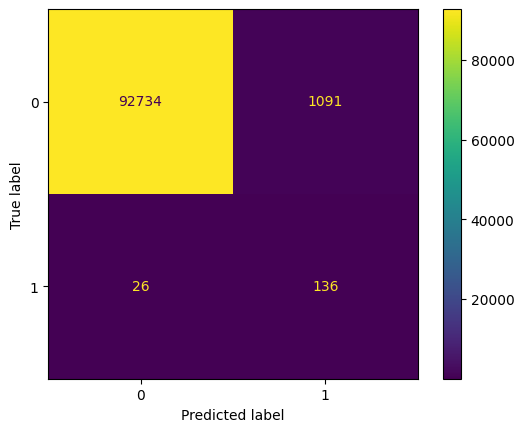

In [132]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()

In [133]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     93825
           1       0.11      0.84      0.20       162

    accuracy                           0.99     93987
   macro avg       0.56      0.91      0.59     93987
weighted avg       1.00      0.99      0.99     93987



In [134]:
import joblib

joblib.dump(value= clf_svm, filename='SVMModel.pkl')

['SVMModel.pkl']